# ASL Dataset using CNN

### Download data

In [ ]:
!wget -O archive.zip '<dataset-link>'

In [2]:
%%capture
!unzip -o archive.zip

### Imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sn
import scipy
import cv2
import imageio

import os

In [4]:
np.random.seed(0)

## Dataset

### Load dataset

In [5]:
train_path = 'asl_alphabet_train/asl_alphabet_train'

In [6]:
IMG_DIM = 100

In [7]:
def create_dataset(path, test_train_ratio=0.2):
  x_train=[]
  x_test=[]
  y_train=[]
  y_test=[]
  label_names = []
  
  for class_folder in sorted(os.listdir(train_path)):
    x_class = []
    y_class = []
    
    for image_file in os.listdir(os.path.join(path, class_folder)):
      image_path = os.path.join(path, class_folder, image_file)
      image = cv2.imread(image_path)[10:-10, 10:-10] # images have random blue frames
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image = cv2.resize(image, (IMG_DIM, IMG_DIM), cv2.INTER_LINEAR)

      x_class.append(image)
      y_class.append(len(label_names))

    label_names.append(class_folder)
    cut = int(test_train_ratio*len(x_class))
    x_test += x_class[:cut]
    y_test += y_class[:cut]
    x_train += x_class[cut:]
    y_train += y_class[cut:]
    
  return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test), label_names


x_train, y_train, x_test, y_test, label_names = create_dataset(train_path)
print("Train: " + str(len(x_train)))
print("Test: " + str(len(x_test)))

Train: 69600
Test: 17400


### Check distribution

In [8]:
train_distr = np.unique(y_train, return_counts=True)
test_distr = np.unique(y_test, return_counts=True)

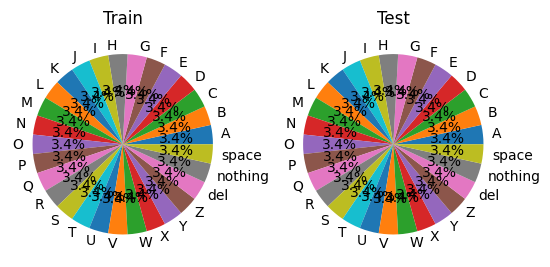

In [9]:
plt.subplot(1, 2, 1)
plt.pie(train_distr[1], labels=label_names, autopct='%1.1f%%')
plt.title("Train")
plt.plot()

plt.subplot(1, 2, 2)
plt.pie(test_distr[1], labels=label_names, autopct='%1.1f%%')
plt.title("Test")
plt.plot()
plt.show()

Dataset is balanced, no need for resampling.

### Visualize augmentation

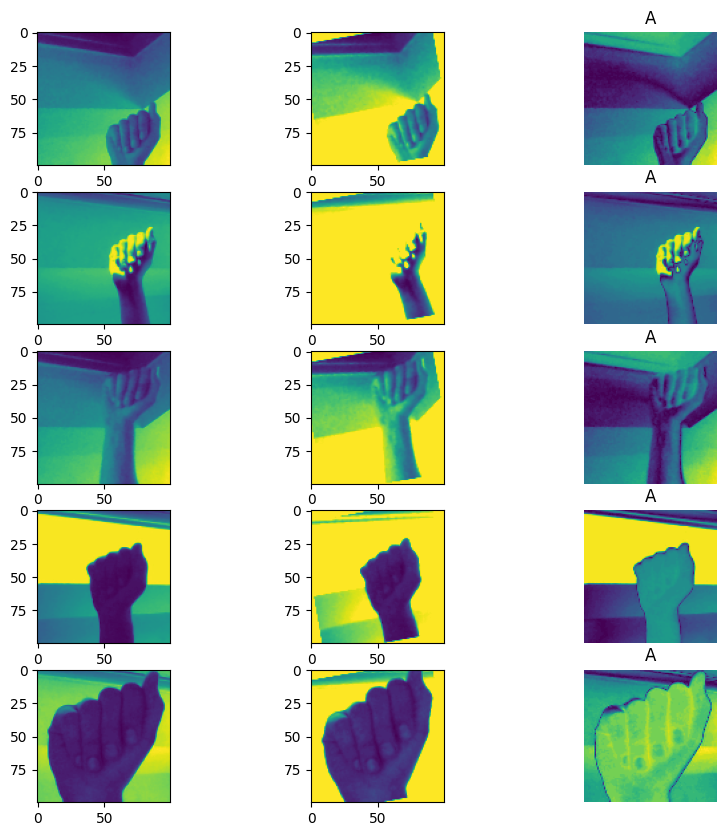

In [10]:
plt.figure(figsize=(10,10))
M = cv2.getRotationMatrix2D((IMG_DIM//2, IMG_DIM//2), 10, 1)
for i in range(5):
  ax = plt.subplot(5,3,i*3+1)
  plt.imshow(x_train[i])
  ax = plt.subplot(5,3,i*3+2)
  plt.imshow(cv2.convertScaleAbs(
    cv2.warpAffine(x_train[i], M, (IMG_DIM, IMG_DIM), borderValue=255),
    alpha=1.5, beta=50)
  )
  ax = plt.subplot(5,3,i*3+3)
  plt.imshow(cv2.convertScaleAbs(
      x_train[i],
      alpha=0.5, beta=-50)
  )
  plt.title(label_names[y_train[i]])
  plt.axis("off")

### Data augmentation

In [11]:
# train
for i in range(0, len(x_train), 2):
  x_train[i] = cv2.convertScaleAbs(x_train[i], alpha=1.5-np.random.rand(), beta=100*(np.random.rand()-0.5))

x_train_copy = x_train.copy()

for i in range(0, len(x_train)):
  M = cv2.getRotationMatrix2D((IMG_DIM//2, IMG_DIM//2), 20*(np.random.rand()-0.5), 1)
  x_train_copy[i] = cv2.warpAffine(x_train_copy[i], M, (IMG_DIM, IMG_DIM), borderValue=255)

x_train = np.concatenate([x_train, x_train_copy])
y_train = np.concatenate([y_train, y_train])

# test
for i in range(0, len(x_test), 2):
  x_test[i] = cv2.convertScaleAbs(x_test[i], alpha=1.5-np.random.rand(), beta=100*(np.random.rand()-0.5))

x_test_copy = x_test.copy()

for i in range(0, len(x_test)):
  M = cv2.getRotationMatrix2D((IMG_DIM//2, IMG_DIM//2), 20*(np.random.rand()-0.5), 1)
  x_test_copy[i] = cv2.warpAffine(x_test_copy[i], M, (IMG_DIM, IMG_DIM), borderValue=255)

x_test = np.concatenate([x_test, x_test_copy])
y_test = np.concatenate([y_test, y_test])

### Shuffle dataset

In [12]:
train_perm = np.random.permutation(x_train.shape[0])
test_perm = np.random.permutation(x_test.shape[0])

x_train = x_train[train_perm]
y_train = y_train[train_perm]
x_test = x_test[test_perm]
y_test = y_test[test_perm]

### Visualize data

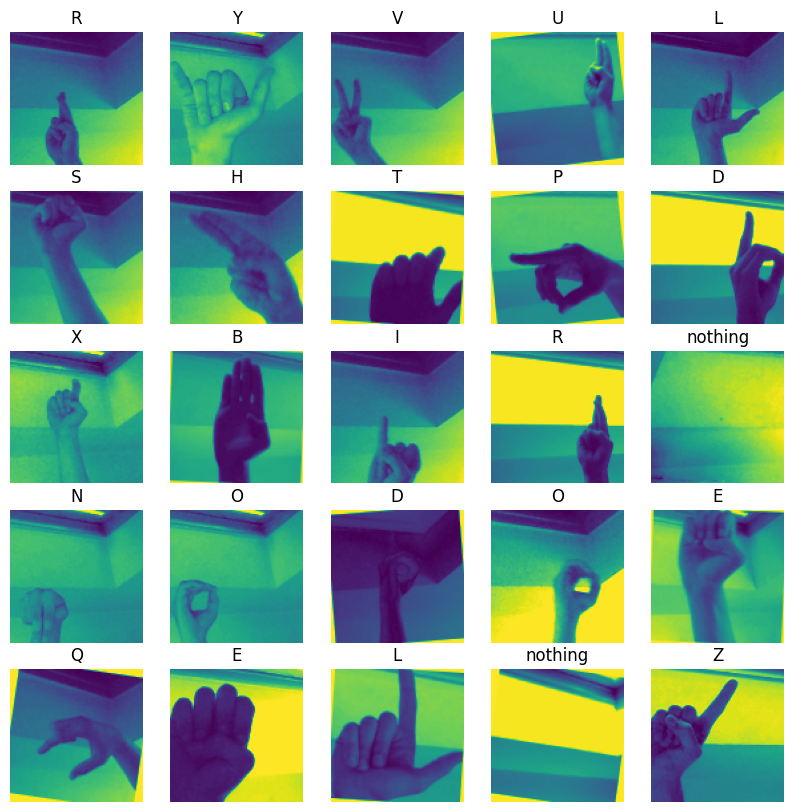

In [13]:
plt.figure(figsize=(10,10))
for i in range(25):
  ax = plt.subplot(5,5,i+1)
  plt.imshow(x_train[i])
  plt.title(label_names[y_train[i]])
  plt.axis("off")

### Prepare dataset

Change labels to one-hot encoded arrays

In [14]:
y_train = tf.one_hot(y_train, len(label_names))
y_test = tf.one_hot(y_test, len(label_names))

Add one more dimension ( *(100,100)->(100,100,1)* )

In [15]:
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

## Model

In [16]:
def make_model():
  input_layer = tf.keras.layers.Input(shape=(100,100,1))
  
  model = tf.keras.layers.Rescaling(1./255)(input_layer)
  
  model = tf.keras.layers.Conv2D(64, 7)(model)
  model = tf.keras.layers.Activation('relu')(model)
  model = tf.keras.layers.MaxPooling2D()(model)
  model = tf.keras.layers.Dropout(0.1)(model)

  model = tf.keras.layers.Conv2D(32, 3)(model)
  model = tf.keras.layers.Activation('relu')(model)
  model = tf.keras.layers.MaxPooling2D()(model)
  model = tf.keras.layers.Dropout(0.1)(model)

  model = tf.keras.layers.Conv2D(16, 3)(model)
  model = tf.keras.layers.Activation('relu')(model)
  model = tf.keras.layers.MaxPooling2D()(model)
  model = tf.keras.layers.Dropout(0.1)(model)

  model = tf.keras.layers.Flatten()(model)

  model = tf.keras.layers.Dense(128)(model)
  model = tf.keras.layers.Activation('relu')(model)
  model = tf.keras.layers.Dense(29)(model)

  model = tf.keras.layers.Softmax()(model)

  return tf.keras.Model(inputs=input_layer, outputs=model)

In [17]:
model = make_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 rescaling (Rescaling)       (None, 100, 100, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 94, 94, 64)        3200      
                                                                 
 activation (Activation)     (None, 94, 94, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 47, 47, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 47, 47, 64)        0         
                                                             

In [18]:
optimizer = tf.keras.optimizers.Adam()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

## Training

In [19]:
history = model.fit(x_train, y_train, epochs=15, batch_size=256, verbose=1, validation_data=(x_test, y_test))

Epoch 1/15
544/544 [==============================] - 71s 107ms/step - loss: 1.5591 - categorical_accuracy: 0.5465 - val_loss: 0.5381 - val_categorical_accuracy: 0.8377
Epoch 2/15
544/544 [==============================] - 58s 106ms/step - loss: 0.3993 - categorical_accuracy: 0.8754 - val_loss: 0.2599 - val_categorical_accuracy: 0.9194
Epoch 3/15
544/544 [==============================] - 58s 106ms/step - loss: 0.2238 - categorical_accuracy: 0.9297 - val_loss: 0.1635 - val_categorical_accuracy: 0.9507
Epoch 4/15
544/544 [==============================] - 57s 105ms/step - loss: 0.1525 - categorical_accuracy: 0.9518 - val_loss: 0.1204 - val_categorical_accuracy: 0.9640
Epoch 5/15
544/544 [==============================] - 57s 105ms/step - loss: 0.1191 - categorical_accuracy: 0.9619 - val_loss: 0.1241 - val_categorical_accuracy: 0.9638
Epoch 6/15
544/544 [==============================] - 58s 106ms/step - loss: 0.0903 - categorical_accuracy: 0.9713 - val_loss: 0.0904 - val_categorical_acc

In [20]:
model.save('model.h5')
history.history.keys()

dict_keys(['loss', 'categorical_accuracy', 'val_loss', 'val_categorical_accuracy'])

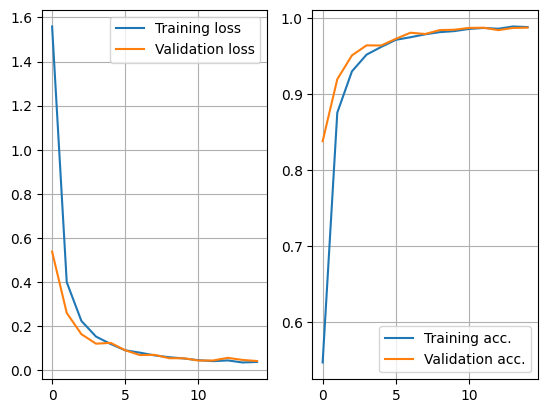

In [21]:
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['categorical_accuracy'], label='Training acc.')
plt.plot(history.history['val_categorical_accuracy'], label='Validation acc.')
plt.legend()
plt.grid()
plt.show()

In [22]:
#model = tf.keras.models.load_model('model.h5')

### Statistics

In [23]:
true_y = np.argmax(y_test, axis=1)
pred_y = np.concatenate([np.argmax(model(x_test_part), axis=1) for x_test_part in np.array_split(x_test, 1000)])
print(classification_report(true_y, pred_y))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99      1200
           1       0.99      0.99      0.99      1200
           2       1.00      1.00      1.00      1200
           3       0.97      1.00      0.98      1200
           4       0.98      0.98      0.98      1200
           5       1.00      1.00      1.00      1200
           6       0.98      0.99      0.99      1200
           7       1.00      1.00      1.00      1200
           8       0.99      0.99      0.99      1200
           9       1.00      0.99      0.99      1200
          10       0.96      0.99      0.98      1200
          11       1.00      0.99      1.00      1200
          12       0.99      0.99      0.99      1200
          13       0.99      0.99      0.99      1200
          14       0.99      0.97      0.98      1200
          15       0.99      1.00      0.99      1200
          16       1.00      0.99      0.99      1200
          17       0.98    

<Axes: >

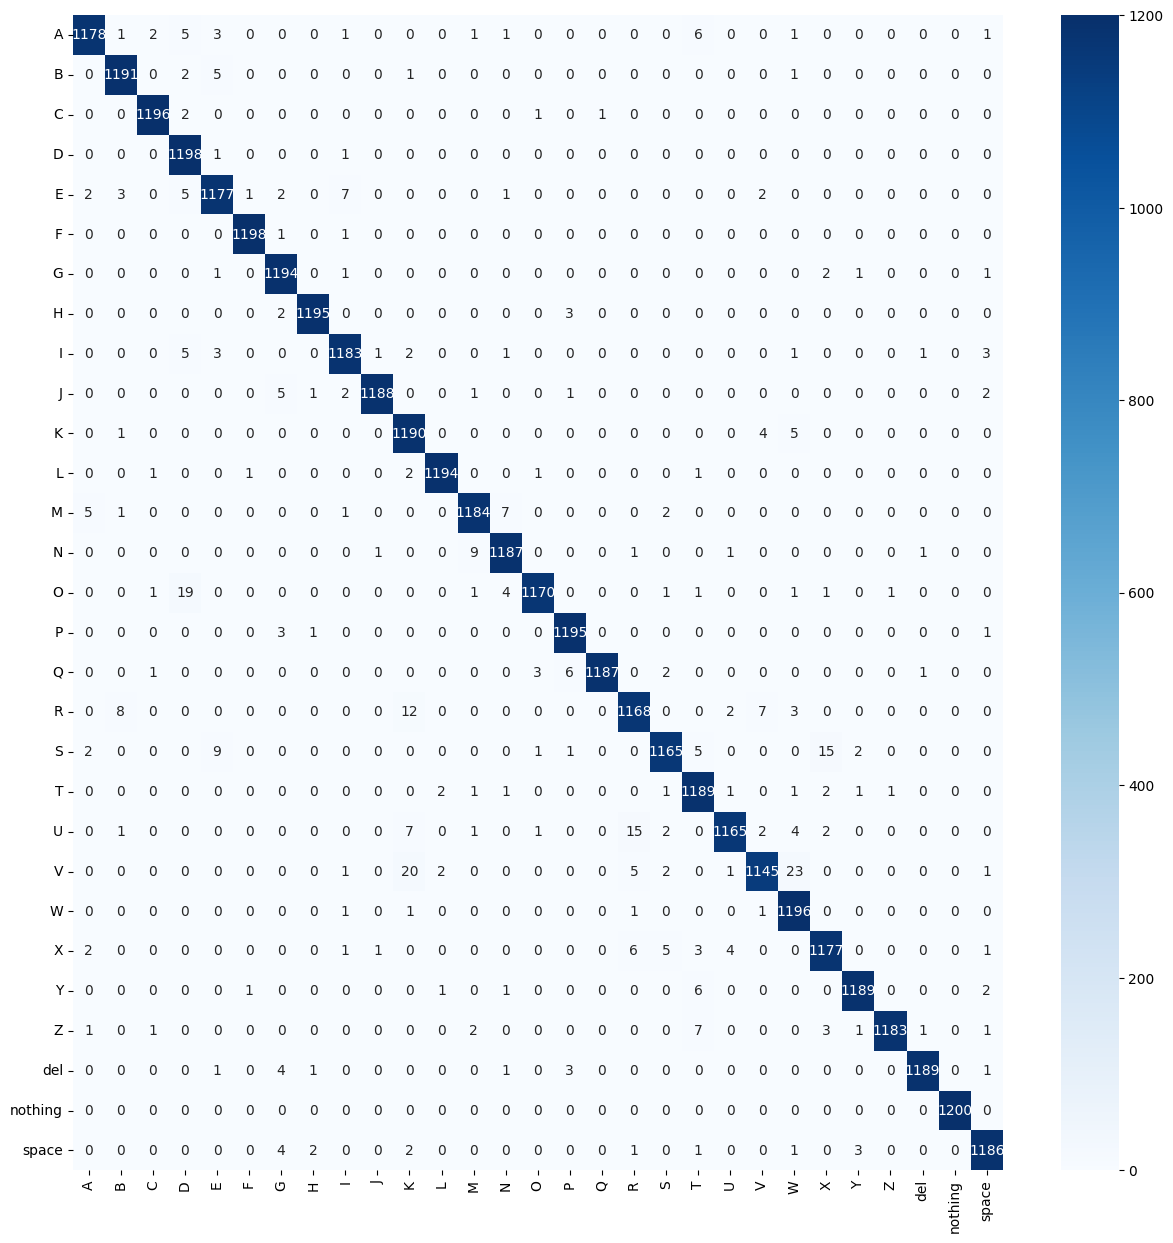

In [24]:
fig, ax = plt.subplots(figsize=(15,15))
matrix = confusion_matrix(true_y, pred_y)
matrix_df = pd.DataFrame(matrix, index=label_names, columns=label_names)
sn.heatmap(matrix_df, cmap='Blues', annot=True, fmt='g', ax=ax)

## Inference

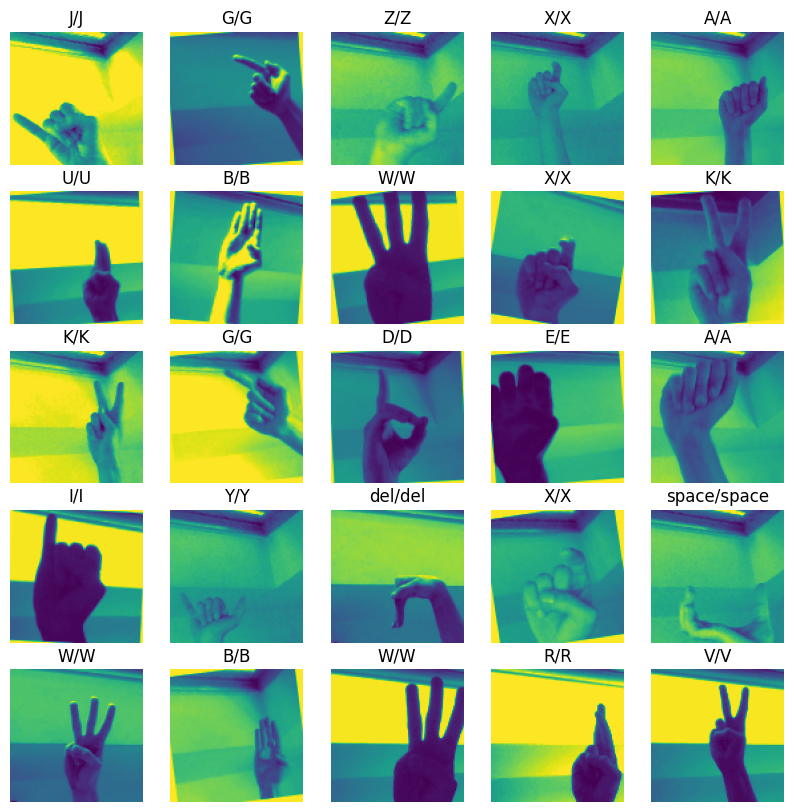

In [25]:
plt.figure(figsize=(10,10))
for i in range(25):
  ax = plt.subplot(5,5,i+1)
  plt.imshow(x_test[i])
  plt.title(label_names[np.argmax(y_test[i])] + "/" + label_names[np.argmax(model(x_test[i:i+1]))])
  plt.axis("off")

### Custom test

Let's play with my custom video. I want to spell out "I love you". Let's see how it should look like.

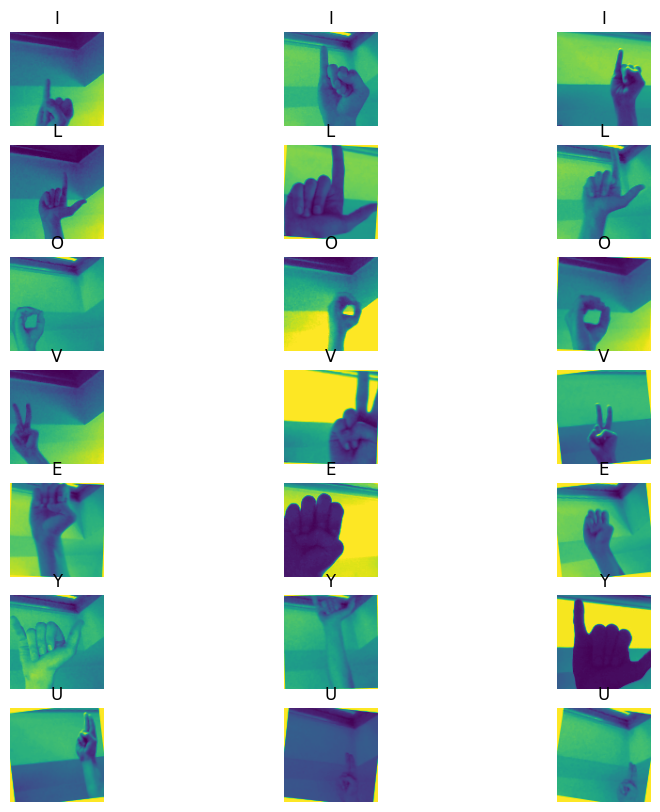

In [26]:
letters = ["I","L","O","V","E","Y","U"]
letters = [ord(letter) - ord('A') for letter in letters]

plt.figure(figsize=(10,10))
i = 1
for letter in letters:
  j = 1
  k = 0
  while j <= 3:
    if np.argmax(y_train[k]) == letter:
      ax = plt.subplot(7,3,i)
      i += 1
      plt.imshow(x_train[k])
      plt.title(chr(ord('A')+letter))
      plt.axis("off")
      j += 1
    k += 1

Download the video

In [ ]:
!wget -O vid.mp4 "https://raw.githubusercontent.com/AndrejGobeX/ASL_Alphabet_Classifier/main/demo.mp4"

Extract frames from video and run inference

In [31]:
font                   = cv2.FONT_HERSHEY_SIMPLEX
bottomLeftCornerOfText = (10,30)
fontScale              = 1
fontColor              = (0,0,0)
thickness              = 1
lineType               = 2

images = []
preds = []

vidcap = cv2.VideoCapture('vid.mp4')
success,image = vidcap.read()
count = 0
while success:
  image = image[20:, ]
  image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), (IMG_DIM,IMG_DIM))
  image = np.expand_dims(image, axis=-1)

  inference = model(np.array([image]))[0]
  pred = np.argmax(
      inference
  )

  image = cv2.resize(image, (200,200))

  cv2.putText(image, label_names[pred] + ": " + str(np.round(inference[pred]*100 ,2)),
              bottomLeftCornerOfText,
              font,
              fontScale,
              fontColor,
              thickness*(2 if inference[pred] > 0.85 else 1),
              lineType)

  images.append(image)
  preds.append(pred)
  success,image = vidcap.read()
  count += 1
print(count)

1049


Export to gif

In [29]:
imageio.mimsave('final.gif', images, fps=30)